# ECS708P mini-project submission

The mini-project consists of two components:


1.   **Basic solution** : Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2.   **Advanced solution** : There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).  




#Mini Project





# 1 Basic solution


In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MScProject/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


The below cell defines a function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

The problem is to identify the intonation of a short audio signal.The next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (X) and their labels (y).

In [ ]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

Only 500 files will be used to train and test the model.Using all 20000 files will be time consuming.

In [ ]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True)

100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (500, 4)
The shape of y is (500,)
The labels vector is ['bored' 'question' 'excited' 'excited' 'question' 'excited' 'neutral'
 'bored' 'neutral' 'neutral' 'neutral' 'bored' 'bored' 'question'
 'neutral' 'bored' 'neutral' 'neutral' 'question' 'excited' 'neutral'
 'excited' 'bored' 'excited' 'bored' 'neutral' 'bored' 'bored' 'bored'
 'excited' 'question' 'excited' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'question' 'question' 'bored' 'question' 'bored' 'bored'
 'question' 'neutral' 'bored' 'excited' 'bored' 'bored' 'question'
 'question' 'bored' 'bored' 'question' 'excited' 'neutral' 'bored'
 'neutral' 'neutral' 'neutral' 'excited' 'bored' 'excited' 'excited'
 'question' 'excited' 'question' 'bored' 'question' 'neutral' 'bored'
 'bored' 'neutral' 'bored' 'question' 'neutral' 'excited' 'question'
 'excited' 'question' 'neutral' 'excited' 'neutral' 'excited' 'neutral'
 'neutral' 'excited' 'excited' 'bored' 'bored' 'question' 'question'
 'question' 'bored' 'neutr

As part of preprocessing the dataset, all items with a NaN are removed.

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


To identify the best model to solve this problem, a cross-validation approach was taken. Using K-fold cross validation approach, various machine learning models were compared as seen in the next cell. Default hyperparameters were used for all models. There will be ten splits to ensure the datatset is divided evenly and there is sufficient data in each fold.

NB: 0.440000 (0.057271)
RFC: 0.470000 (0.067676)
KNN: 0.396000 (0.041761)
CART: 0.394000 (0.094678)
SVM: 0.378000 (0.026000)


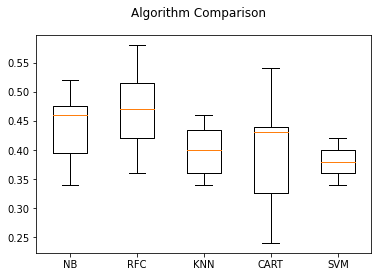

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#create list of machine learning models
models = []
models.append(('NB',GaussianNB()))
models.append(('RFC',RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
results = [] #list for results during cross validation
names = [] # list of all model names.Required when printing out results

for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
 #get average results from all folds
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
 
#plotting boxplot to compare results of each model
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


The above cell was executed multiple times to understand the best model overall. The Random Trees Classifier obtained the highest accuracy among all models whenever executed. On the other hand, the decision tree classifier performed the worst.The boxplot shows the accuracy scores across each cross validation fold for each algorithm.


From the results it is clear that it would be best to study Random Forest Classifiers further. Using GridSearch, the next cell attempts to improve the accuracy of this classifier. Various hyperparameters were tested to identfy the best version of the model. The parameter grid included the default hyperparameters so results could be compared and understand why this classifer performed the best.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

#normalisation
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_test  = (X_test-mean)/sd

#parameters being tested
tuned_parameters = param_grid = {
    'max_depth': [None,3,4],
    'min_samples_split': [2,3,4],
    'n_estimators': [50,100, 200]
}

print("Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
#printing out accuracy details for each type of RFC
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("Detailed classification report:")
  print()
  y_true, y_pred = y_test, clf.predict(X_test)
  print(classification_report(y_true, y_pred))
  print()

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

Grid scores on development set:

0.423 (+/-0.106) for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Detailed classification report:

              precision    recall  f1-score   support

       bored       0.59      0.36      0.45        36
     excited       0.43      0.57      0.49        37
     neutral       0.49      0.62      0.55        39
    question       0.60      0.47      0.53        38

    accuracy                           0.51       150
   macro avg       0.53      0.50      0.50       150
weighted avg       0.53      0.51      0.50       150


0.420 (+/-0.043) for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Detailed classification report:

              precision    recall  f1-score   support

       bored       0.59      0.36      0.45        36
     excited       0.43      0.57  

# Conclusion

According to the results of the above cell, the random forest classifier was able to obtain the highest accuracy of 0.491 with the hyperparameters: 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100.

# 2 Advanced solution

Using the same dataset, a support vector machine learning model will be developed to identify prime numbers in the dataset. 





The next cell firstly defines a function that calculates whether the number is prime or not by returning true or false.

In [ ]:
def isPrime(yi):
  if yi == 2 or yi == 3: return True
  if yi < 2 or yi%2 == 0: return False
  if yi < 9: return True
  if yi%3 == 0: return False
  r = int(yi**0.5)
  f = 5
  while f <= r:
    print('\t',f)
    if yi % f == 0: return False
    if yi % (f+2) == 0: return False
    f += 6
  return True    


A similar function to the previous solution will also be used to obtain the necessary features. The function will include an if statement to check if number is prime.

In [ ]:
def get_Xy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if (isPrime(yi)==False):
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [ ]:
X,y = get_Xy(files[:500],labels_file=labels,scale_audio=True)

100%|██████████| 500/500 [00:39<00:00, 12.61it/s]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (139, 4)
The shape of y is (139,)
The labels vector is [ 3  5  5  5  2 17 19 13 11 19 13  5  2 19 19  7 17 13  7 11 11 17 11  2
 11  3 11  5 13 13 13  3 17 17  5 11 17 13  7  5  3  5  5 19  3  7  3 19
 19 17  7  5 13 17  3 19  3  5  5  2  5  2  3  2 11  5  7  7 13 17 17 17
 19 11  2  7  2  7 19 17 13  7 11 19  7 11  7  3  7 13  3 13  5  3  3 11
 17 13  7 11  5  7 17  3 13 19 13 19 17 11 17  3 17 11 11  3  3  7 17  5
 17  5 19  5 13  2 17  3  7 17 11 13  7 17 13  2 13  5  3]


As seen in the above output, the labels are only prime numbers.

Creating SVM model

Training Accuracy 0.8041237113402062
Validation  Accuracy 0.11904761904761904
Confusion matrix
[[0 1 0 0 0 1 0 0]
 [0 1 0 0 3 0 0 0]
 [0 4 0 1 1 1 0 0]
 [0 1 2 1 0 2 0 0]
 [0 1 0 0 1 0 1 0]
 [0 2 1 1 0 1 0 0]
 [0 2 1 2 3 0 1 0]
 [0 3 0 0 1 0 2 0]]


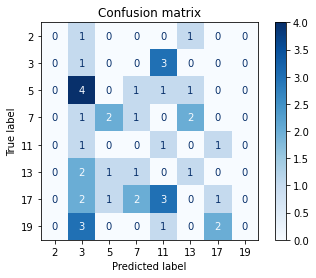

In [ ]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

#normalising 
mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

#svm
model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)
yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

title='Confusion matrix'
disp = plot_confusion_matrix(model, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.show()

As you can see, the training accuracy is high however the validation accuracy is incredibly low indicating that the model is overfitting. Thus to improve the accuracy, GridSearch will be used once again. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

#normalisation
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_test  = (X_test-mean)/sd

#parameters being tested
tuned_parameters = param_grid = {
    'C': [0.01,0.1,1,10,100],
    'gamma': [2,3,4],
    'kernel': ['rbf','linear']
}

print("Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
#printing out accuracy details for each type of SVM
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("Detailed classification report:")
  print()
  y_true, y_pred = y_test, clf.predict(X_test)
  print(classification_report(y_true, y_pred))
  print()

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'gamma': 3, 'kernel': 'rbf'}

Grid scores on development set:

0.165 (+/-0.036) for {'C': 0.01, 'gamma': 2, 'kernel': 'rbf'}

Detailed classification report:

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.11      0.20      0.14         5
           5       0.00      0.00      0.00         6
           7       0.33      0.20      0.25         5
          11       0.00      0.00      0.00         6
          13       0.33      0.14      0.20         7
          17       0.13      0.33      0.19         6
          19       0.00      0.00      0.00         4

    accuracy                           0.12        42
   macro avg       0.11      0.11      0.10        42
weighted avg       0.13      0.12      0.11        42


0.165 (+/-0.036) for {'C': 0.01, 'gamma': 2, 'kernel': 'linear'}

Detailed classification repo

#Conclusion

From the results shown above, the best parameters for the SVM model is {'C': 10, 'gamma': 3, 'kernel': 'rbf'}. It obtained the highest accuracy of 0.196.
